In [1]:
import matplotlib
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import scipy.fftpack
import gc
import patched_gpr
import sklearn.gaussian_process as gp
import importlib
import itertools
np.random.seed(1)




logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [2]:
signal_subsample_rate = 20
SIGNAL_HZ = 52
HZ=SIGNAL_HZ/signal_subsample_rate
CHANNEL_COLS=list(range(1,4))
CHANNELS = len(CHANNEL_COLS)
LABEL_COL = 4
RUN=1
gpr_subsample_rate=10
bandwidth = 40*HZ
n = int(2*bandwidth)-2
WHICH_DATA_FILE=6 # run7/5, run8/6, run9/5, run10/6, run11/6, run12/5, run13/6

In [3]:
150/HZ

57.69230769230769

In [4]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)

In [5]:
def adjust_ax_labels(axs, rng, n_ticks=8, hz=HZ):
    try:
        axs_iterator = iter(axs)
    except TypeError as te:
        axs_iterator = iter([axs])
    for ax in axs_iterator:
        ax.axis("off")
    ax.axis("on")
    x_ticks = np.linspace(rng[0],rng[1],n_ticks)
    x_tick_labels = x_ticks/hz
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(map(lambda x: "{:.01f}".format(x), x_tick_labels)))
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)        

In [6]:
def clear(fig, axs):
    try:
        for ax in axs:
            ax.clear()
    except:
        axs.clear()
    fig.clear()
    plt.close(fig)
    plt.close("all")
    
def plt_gpr_params(X, y, gpr_X, gpr_params, chg_ptses, kernel, filename, hz=HZ, display=False):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    adjust_ax_labels(axs,(np.min(X), np.max(X)),hz=HZ)
    artists = []
    extra_dims = []
    colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for var in range(gpr_params.shape[1]):
        c = next(colors)
        ar = axs[0].plot(gpr_X, gpr_params[:,var],c=c)
        artists.append(ar[0])
    for i, chg_pts in enumerate(chg_ptses):
        if i==0:
            extra_dims.append("true change points")
        elif i==1:
            extra_dims.append("pred change points")
        c = next(colors)
        for chg_pt in chg_pts:
            for ax in axs:
                ar = ax.axvline(chg_pt,c=c,lw=2,linestyle=(i*5,(5,5)))
        artists.append(ar)
    c = next(colors)
    ar = axs[1].plot(X, y, c=c)
    extra_dims.append("raw data")
    artists.append(ar[0])
    axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + extra_dims,loc="lower left")
    if filename:
        plt.savefig(filename)
    if not display:
        clear(fig, axs)

In [7]:
#HB suggests using std(X)*n**(-1/5)... since std(X) depends crucially on the length of the signal, how can this help?

In [8]:
project_dir = "/home/brown/disk2/chest_acc/chest_acc"
os.makedirs(project_dir, exist_ok=1)

In [9]:
data_dir = "/home/brown/disk2/USA/windowed_gaussian_process_study/data/chest_acc"

In [10]:
data_file_format = "{}.csv"

In [11]:
data_files = [os.path.join(data_dir, data_file_format.format(str(i))) for i in range(1,16)]

In [12]:
dat = [np.loadtxt(data_file,delimiter=",") for data_file in data_files]

In [14]:
dats = dat

In [15]:
[dat.shape for dat in dats]

[(162501, 5),
 (138001, 5),
 (102341, 5),
 (122201, 5),
 (160001, 5),
 (140901, 5),
 (163001, 5),
 (138001, 5),
 (166741, 5),
 (126801, 5),
 (104451, 5),
 (114702, 5),
 (67651, 5),
 (116101, 5),
 (103501, 5)]

In [16]:
subsampled_dats = [dat[::signal_subsample_rate] for dat in dats]
Xs = [np.arange(subsampled_dat.shape[0]).reshape(-1,1) for subsampled_dat in subsampled_dats]
indexes = [local_models.local_models.ConstantDistanceSortedIndex(X.flatten()) for X in Xs]
change_pointses = [np.nonzero(np.diff(subsampled_dat[:,LABEL_COL]))[0][:-1] for subsampled_dat in subsampled_dats]

In [17]:
subsampled_dats[0].shape

(8126, 5)

In [18]:
cng_pts = [np.copy(change_points) for change_points in change_pointses]

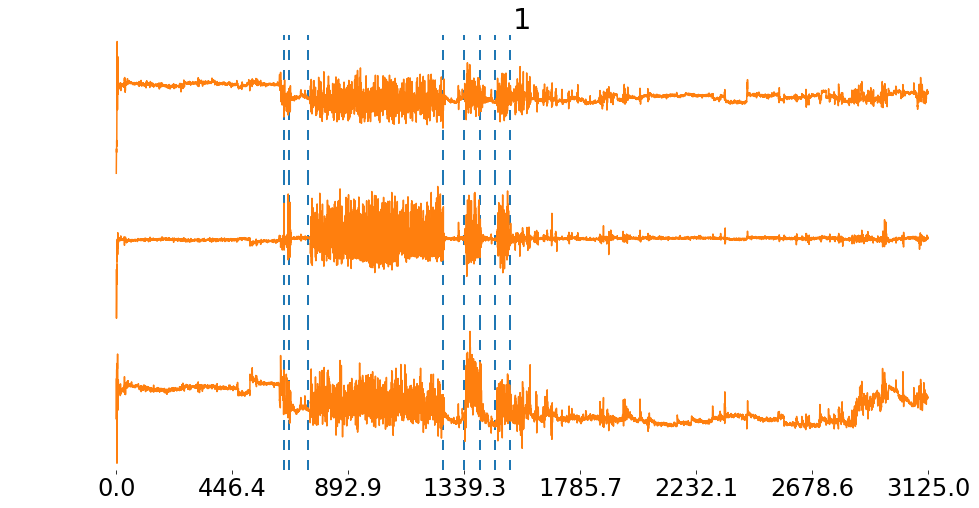

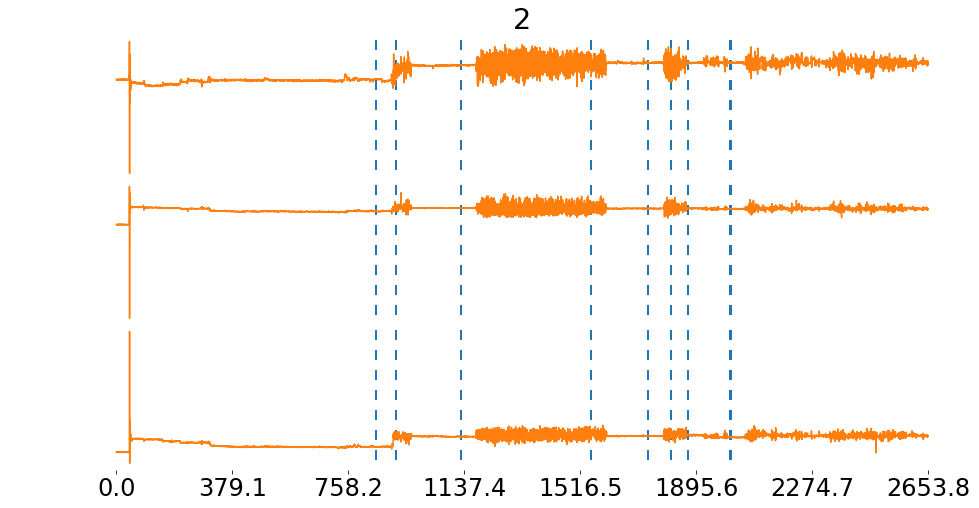

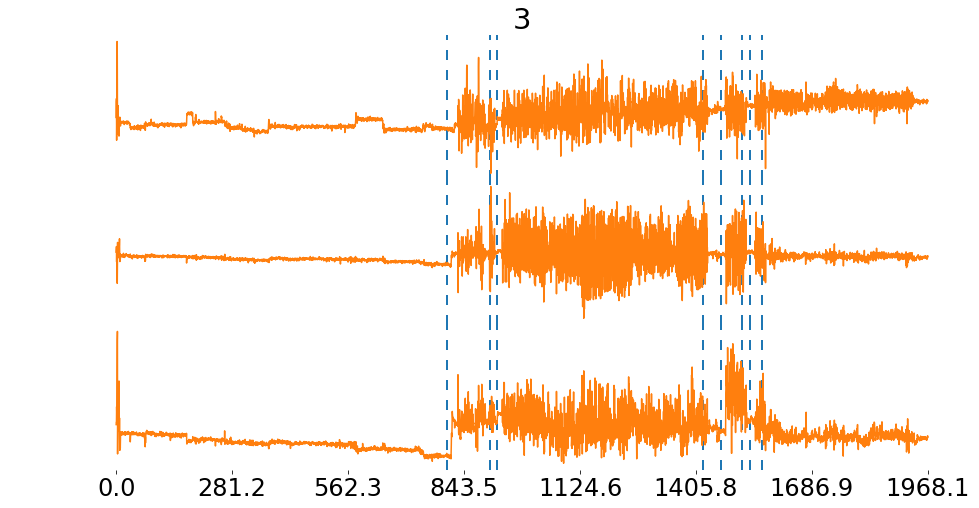

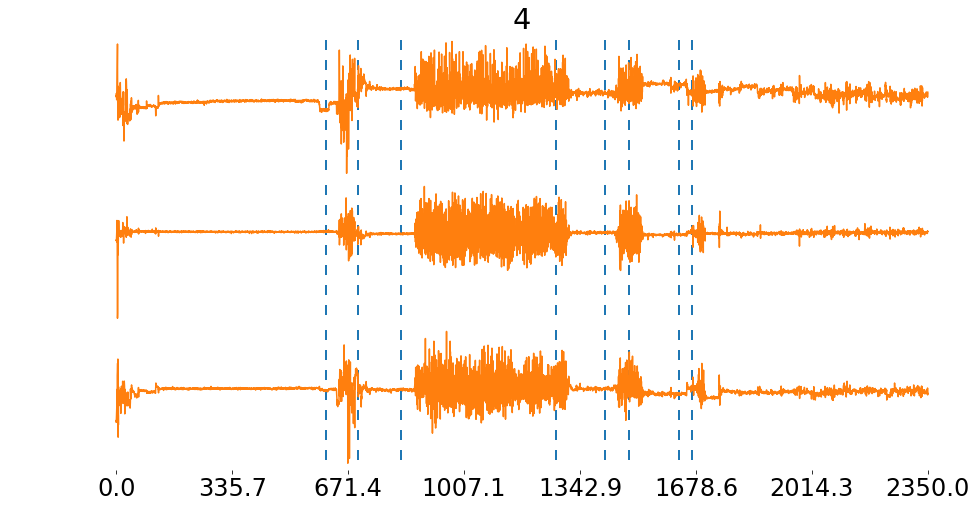

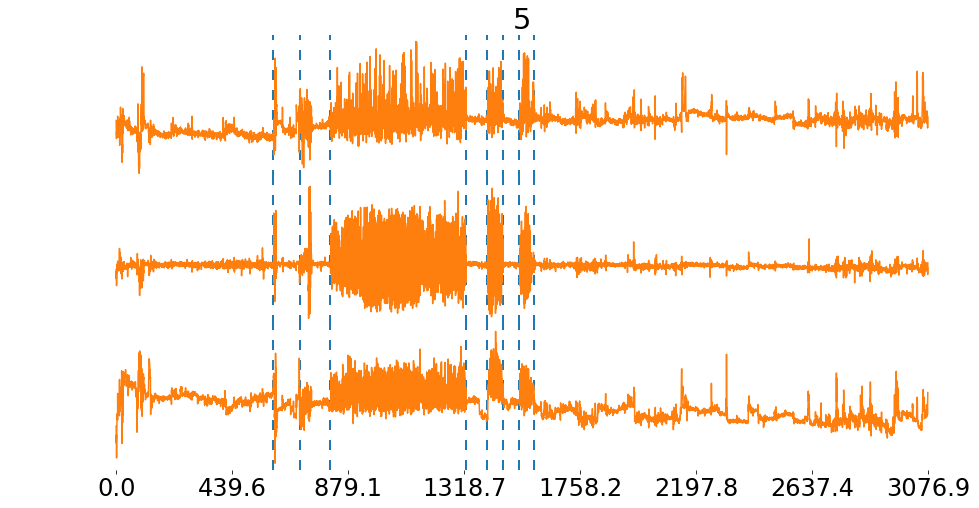

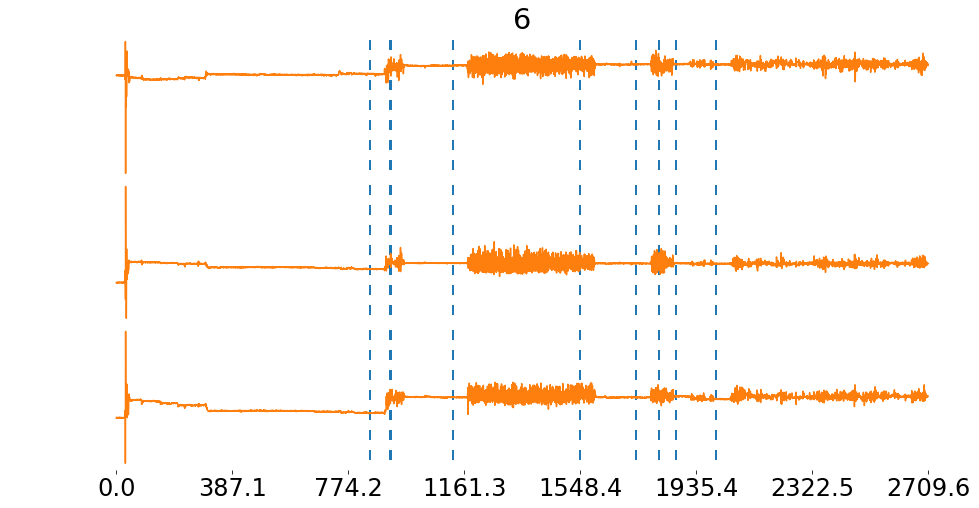

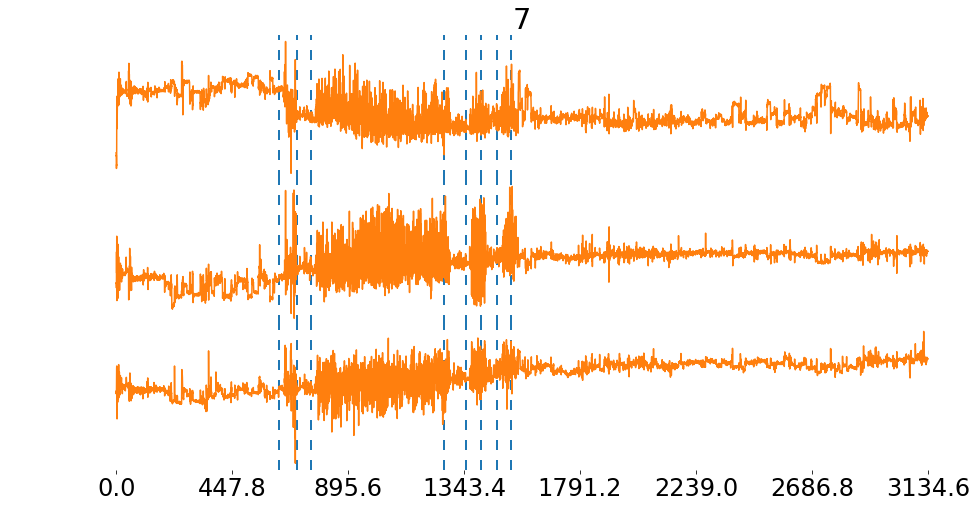

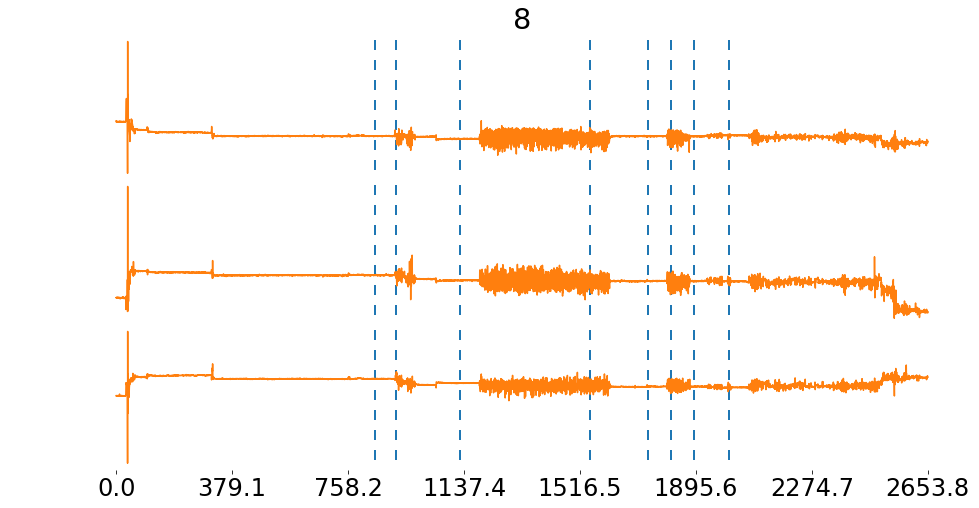

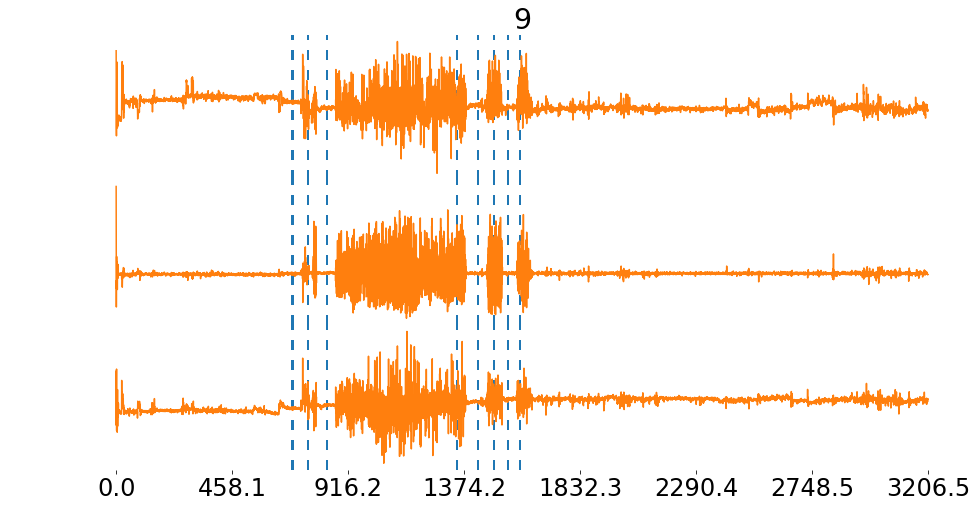

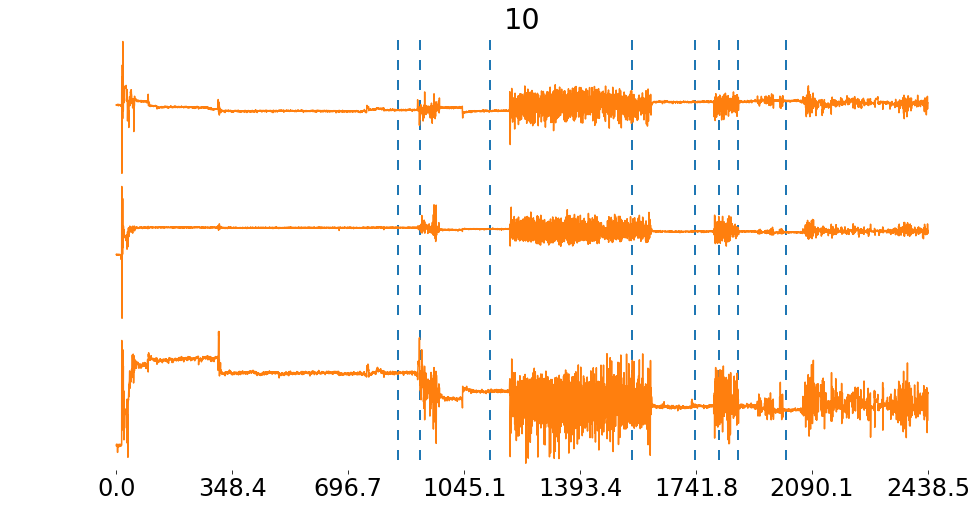

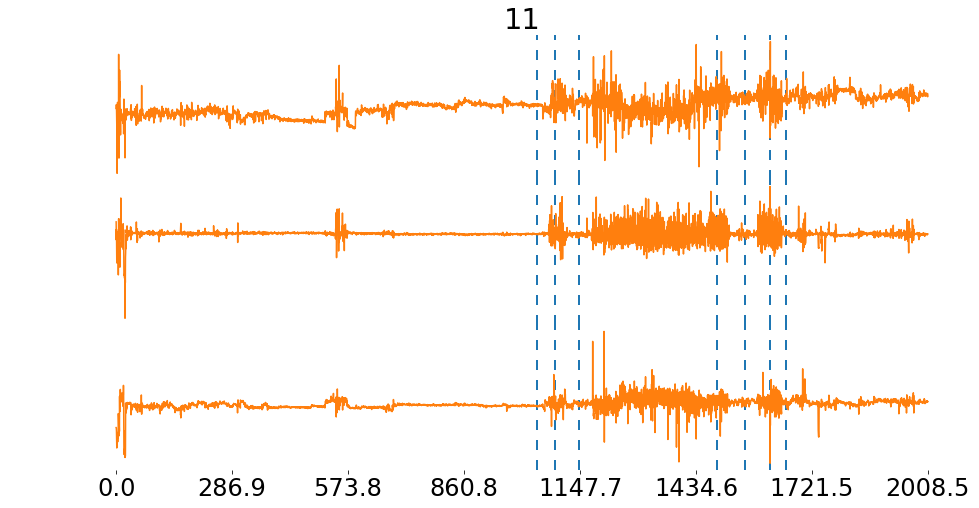

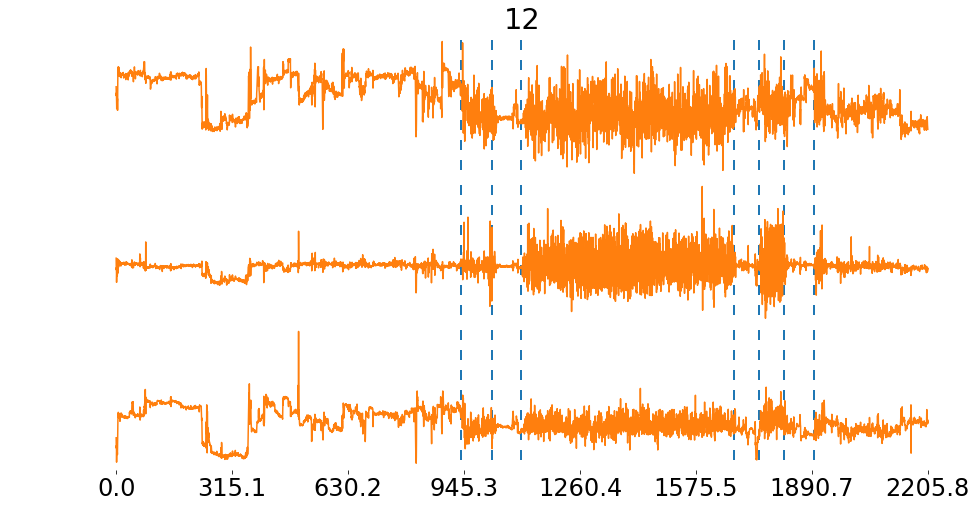

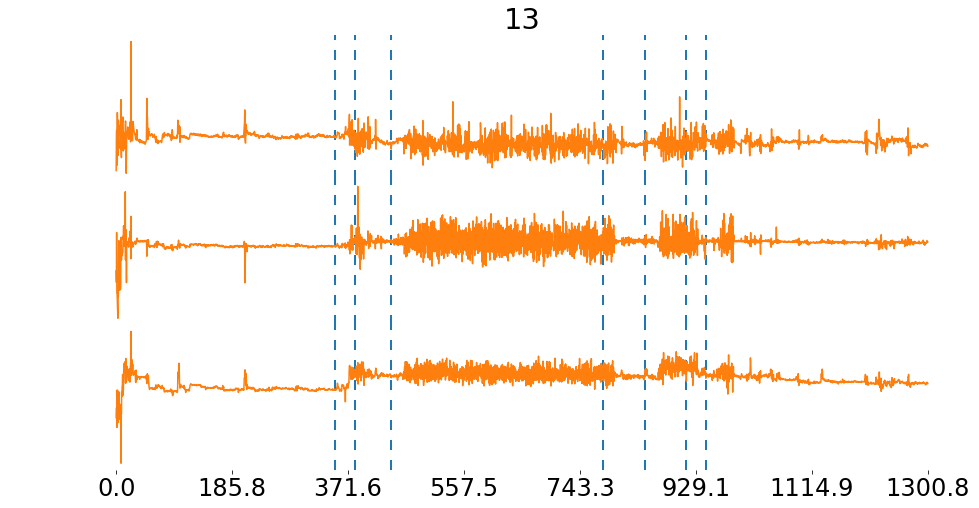

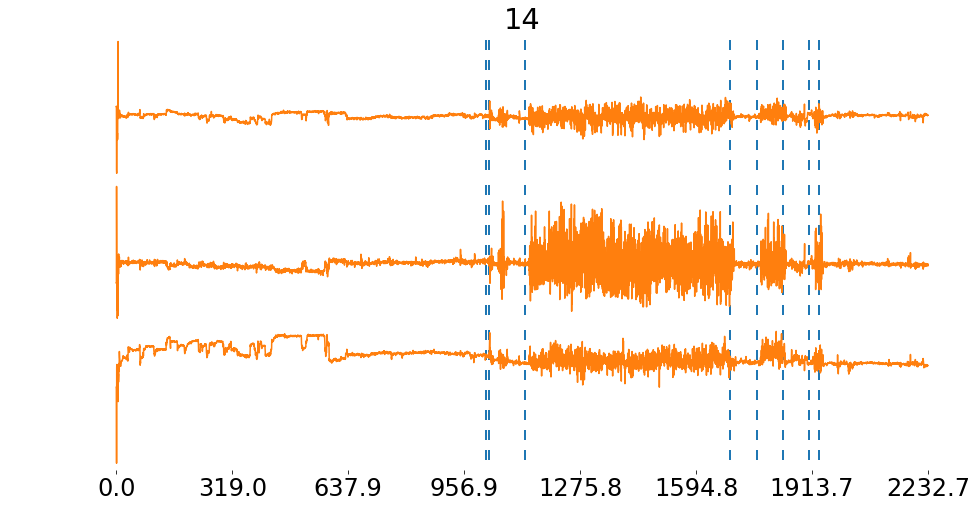

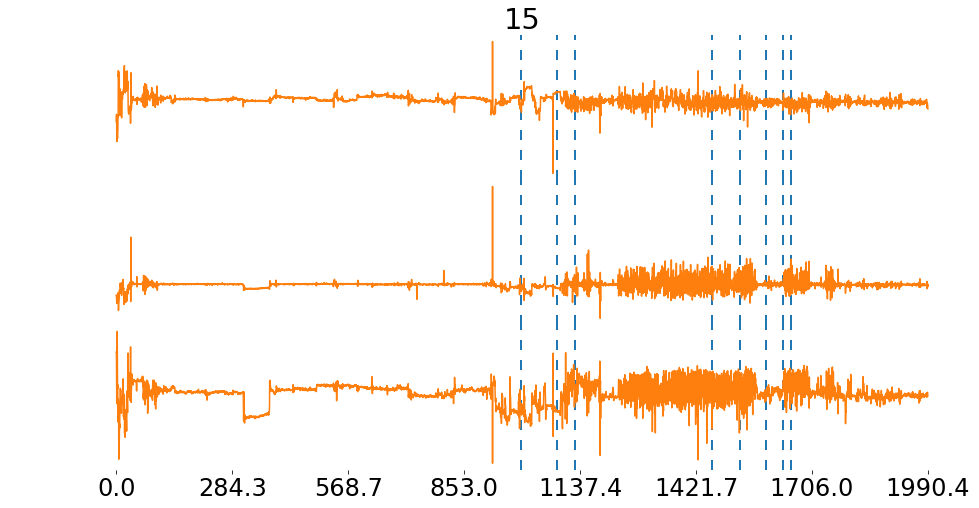

In [20]:
for i, subsampled_dat in enumerate(subsampled_dats):
    fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
    adjust_ax_labels(axs,(np.min(Xs[i]), np.max(Xs[i])),hz=HZ)
    artists = []
    colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])

    c = next(colors)
    for cng_pt in cng_pts[i]:
        for ax in axs:
            ar = ax.axvline(cng_pt,c=c,lw=2,linestyle=(i*5,(5,5)))
    artists.append(ar)
    
    c = next(colors)
    for channel in range(1, subsampled_dat.shape[1]-1):
        ar = axs[channel-1].plot(Xs[i], subsampled_dat[:,channel], c=c)
    axs[0].set_title(str(i+1))
    artists.append(ar[0])


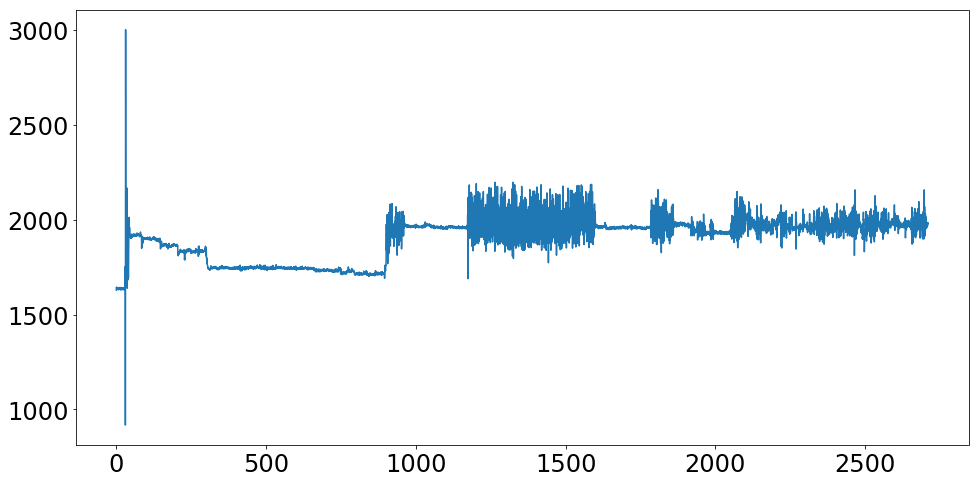

In [13]:
fig = plt.figure(figsize=(16,8))
plt.plot(X/HZ,subsampled_dat[:,3])

In [14]:
class GPR(patched_gpr.GaussianProcessRegressor):
    def fit(self, X,y,sample_weight=None, **kwargs):
        if "beta0" in kwargs:
            self.kernel.theta = kwargs["beta0"]
            del kwargs["beta0"]
        the_model = super().fit(X,y,sample_weight, **kwargs)
        self.coef_ = the_model.kernel_.theta
        self.intercept_ = np.empty((0,))
        return the_model

In [15]:
kernel = np.sum((
    np.prod((
        gp.kernels.ConstantKernel(constant_value=1800, constant_value_bounds="fixed"),
        gp.kernels.RBF(length_scale=HZ, length_scale_bounds="fixed")
    )),
    gp.kernels.WhiteKernel(noise_level=1200, noise_level_bounds=[1e-10,1e10])
))

In [16]:
def fit_local_gprs(y, kernel):
    local_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
    lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
    gpr_models = local_models.local_models.LocalModels(local_regressor)
    gpr_models.fit(X,y,index=index)
    gpr_params = gpr_models.transform(X_gpr_subsampled,r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int(X_gpr_subsampled.shape[0]/10))
    return gpr_params
def plt_local_gprs(gpr_params, y, kernel, filename):
    plt_gpr_params(X, y, X_gpr_subsampled, gpr_params, [change_points], kernel, filename, hz=HZ, display=True)

In [17]:
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

In [19]:
gpr_paramses=np.empty((X_gpr_subsampled.shape[0], 1, CHANNELS))
for i, channel in enumerate(CHANNEL_COLS):
    y = subsampled_dat[:,channel]
    gpr_paramses[:,:,i] = fit_local_gprs(y, kernel)

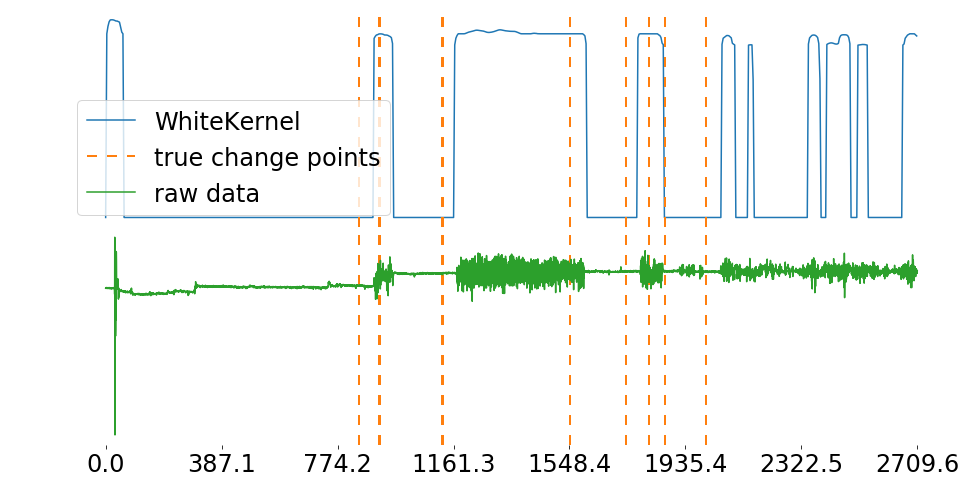

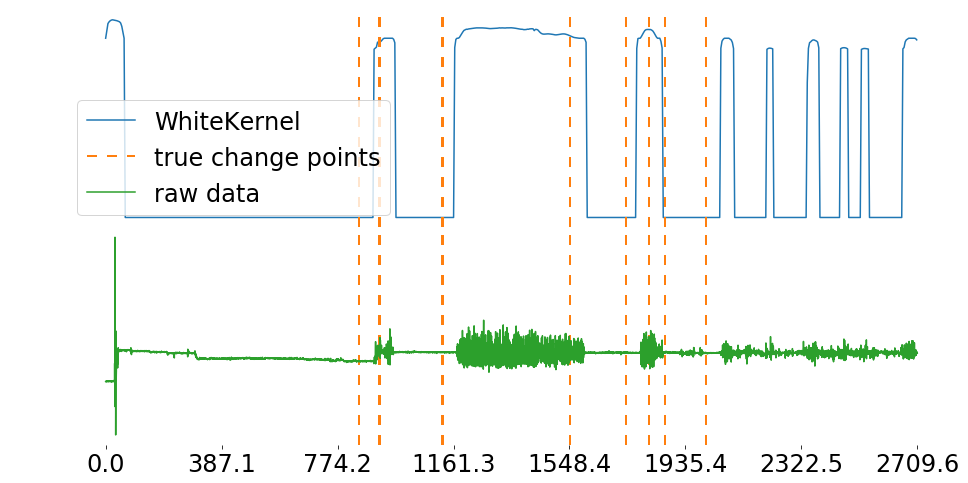

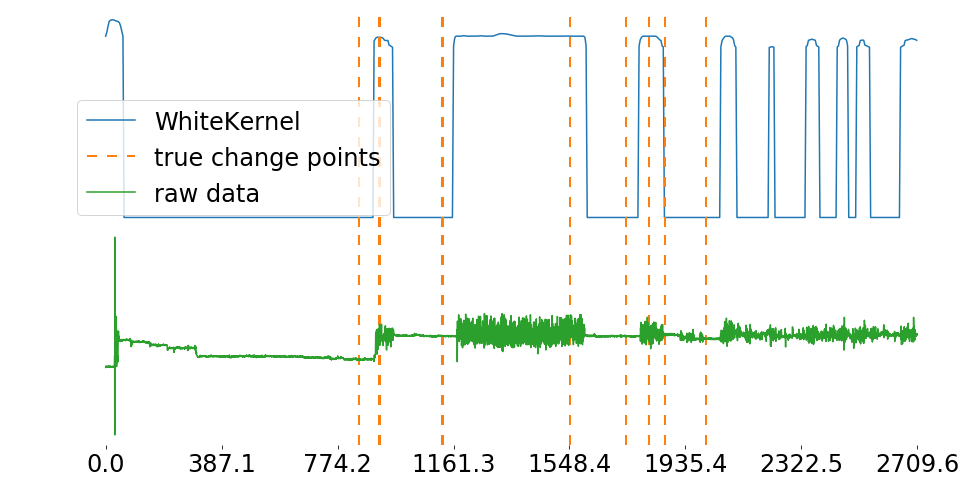

In [20]:
for i, channel in enumerate(CHANNEL_COLS):
    filename = os.path.join(project_dir, "{:01d}_axis_train_plt_f{:03d}_c{:10.02f}_r{:05.02f}_w{:10.02f}_k{}.png".format(channel, WHICH_DATA_FILE, kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, kernel.k2.noise_level, lm_kernel))
    y = subsampled_dat[:,channel]
    plt_local_gprs(gpr_paramses[:,:,i],y,kernel,filename)

In [21]:
def fit_meanshift(gpr_paramses, kernel):
    mean_regressor = local_models.TLS_models.LinearODR_mD(0)
    mean_models = local_models.local_models.LocalModels(mean_regressor)
    mean_models.fit(gpr_paramses)
    for i, (dat, report) in enumerate(local_models.algorithms.local_tls_shift_till_convergence(
                mean_models, gpr_paramses, kernel=kernel, report=True)):
        if not i%100:
            #print(report)
            pass
    return dat
    
def cleanup_meanshift(meanshifted_data, tol=1e-7): 
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(meanshifted_data)
    bins = bt.query_radius(meanshifted_data, r=tol)
    cleanuped = np.empty(meanshifted_data.shape)
    for i, the_bin in enumerate(bins):
        cleanuped[i] = np.mean(meanshifted_data[the_bin], axis=0)
    return cleanuped
    
def pick_optimal_meanshift_bandwidth(initial_bandwidths, gpr_paramses, iterations=7):
    #go middle of the road to get two clusters.
    #i.e. find the minimum bandwidth giving 3, the max giving 1, then take their average
    print(iterations)
    checked_bandwidths = []
    given_n_clusters = []
    if iterations == 0:
        return checked_bandwidths, given_n_clusters
    for bandwidth in initial_bandwidths:
        ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
        fitted_meanshift = fit_meanshift(gpr_paramses, ms_kernel)
        fitted_meanshift = cleanup_meanshift(fitted_meanshift)
        observed_clusters = np.unique(fitted_meanshift, axis=0).shape[0]
        checked_bandwidths.append(bandwidth)
        given_n_clusters.append(observed_clusters)
    #get half of the ones, and half of the twos:
    the_ones = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==1]
    the_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==2]
    the_more_than_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]>2]
    median_the_ones = np.median(the_ones) if the_ones else max(initial_bandwidths)*2
    median_the_more_than_twos = np.median(the_more_than_twos) if the_more_than_twos else min(initial_bandwidths)/2
    median_the_twos = np.median(the_twos) if the_twos else np.mean([median_the_ones, median_the_more_than_twos])
    sub_checked, sub_n_clusters = pick_optimal_meanshift_bandwidth(
        np.concatenate((
            np.linspace(median_the_more_than_twos, median_the_twos, len(initial_bandwidths)),
            np.linspace(median_the_twos, median_the_ones, len(initial_bandwidths))
        )),
        gpr_paramses,
        iterations - 1
    )
    return checked_bandwidths + sub_checked, given_n_clusters + sub_n_clusters 

In [22]:
def mean_d_half_neighbors(dat):
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(dat)
    dz, iz = bt.query(dat, k=int(dat.shape[0]/2), return_distance=True, sort_results=True)
    return np.mean([dz[i][-1] for i in range(len(dz))])

In [24]:
flattened_params = gpr_paramses.transpose([0,2,1]).reshape(gpr_paramses.shape[0],-1)

In [25]:
halfspace_bw = mean_d_half_neighbors(flattened_params)

In [26]:
bs, ns = pick_optimal_meanshift_bandwidth([halfspace_bw, halfspace_bw/4, halfspace_bw/16], flattened_params, iterations=5)

5
4
3
2
1
0


In [27]:
sorted_bs_indices = sorted(list(range(len(bs))), key=lambda i: bs[i])
sorted_bs = [bs[i] for i in sorted_bs_indices]
sorted_ns = [ns[i] for i in sorted_bs_indices]

### The optimal bandwidth is something that robustly gives 2 clusters

In [28]:
optimal_bandwidth = np.median([bs[i] for i in range(len(bs)) if ns[i] ==2])
optimal_bandwidth

36.42811351857348

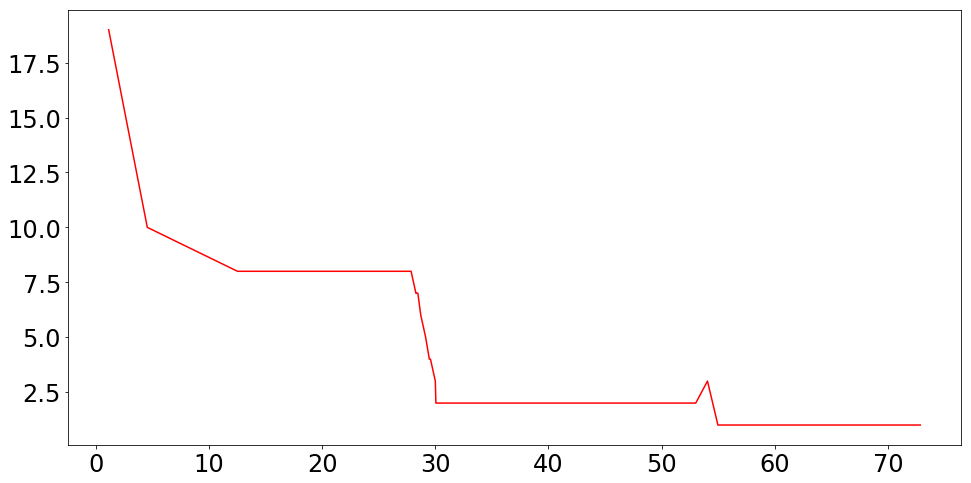

In [29]:
fig = plt.figure(figsize=(16,8))
plt.plot(sorted_bs,sorted_ns,c='r')
plt.savefig(os.path.join(project_dir, "meanshift_clusters.png"))

In [30]:
list(zip(sorted_bs, sorted_ns))

[(1.1383785474554213, 19),
 (4.553514189821685, 10),
 (4.553514189821685, 10),
 (12.522164022009633, 8),
 (18.21405675928674, 8),
 (20.490813854197583, 8),
 (20.490813854197583, 8),
 (20.490813854197583, 8),
 (23.67827378707276, 8),
 (23.67827378707276, 8),
 (24.837350126300098, 8),
 (25.99642646552744, 8),
 (26.575964635141105, 8),
 (26.865733719947944, 8),
 (27.004318934420773, 8),
 (27.155502804754775, 8),
 (27.43267323370044, 8),
 (27.86102753298011, 8),
 (28.289381832259778, 7),
 (28.314579143982115, 7),
 (28.459463686385533, 7),
 (28.717736131539446, 6),
 (29.146090430819115, 5),
 (29.473655483209452, 4),
 (29.574444730098786, 4),
 (30.002799029378455, 3),
 (30.053193652823122, 2),
 (30.431153328658123, 2),
 (30.63273182243679, 2),
 (30.85950762793779, 2),
 (31.28786192721746, 2),
 (31.716216226497128, 2),
 (31.79180816166413, 2),
 (32.1445705257768, 2),
 (32.57292482505647, 2),
 (32.95088450089147, 2),
 (33.001279124336136, 2),
 (33.240653585698304, 2),
 (33.429633423615805, 2),

In [31]:
ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=optimal_bandwidth)
fitted_meanshift = fit_meanshift(flattened_params, ms_kernel)
fitted_meanshift = cleanup_meanshift(fitted_meanshift)

In [32]:
detected_chng = np.nonzero(np.any(np.diff(fitted_meanshift, axis=0) != 0, axis=1))[0]

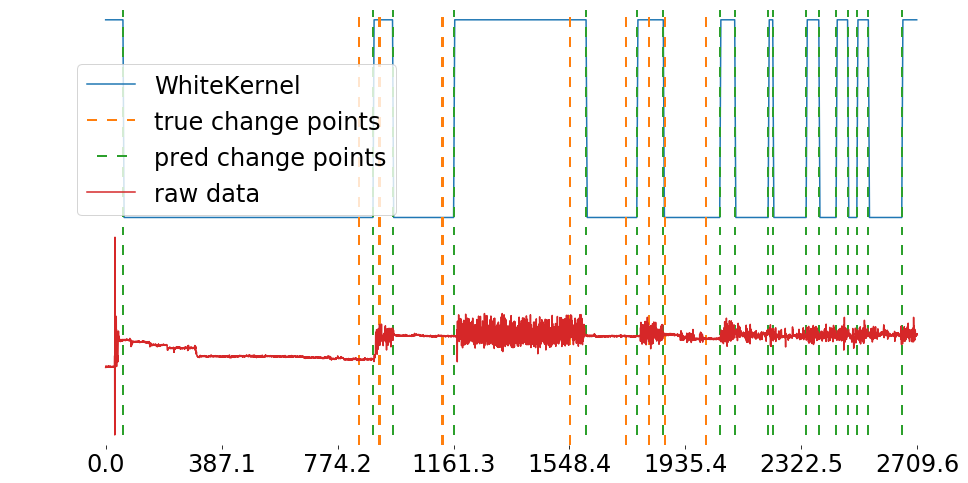

In [33]:
filename = os.path.join(project_dir, "all_axis_train_meanshifted_plt_f{:03d}_c{:10.02f}_r{:05.02f}_w{:10.02f}_k{}.png".format(WHICH_DATA_FILE, kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, kernel.k2.noise_level, lm_kernel))
plt_gpr_params(X, y, X_gpr_subsampled, np.mean(fitted_meanshift, axis=1, keepdims=True), (change_points, detected_chng*10), kernel, None, hz=HZ, display=True)